In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0,'..')

In [3]:
from src.connectors import mongo,queries

In [4]:
from datetime import datetime

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import plotly.plotly as py
import plotly.offline as pyo
import plotly.graph_objs as go

In [7]:
from src.layouts import emotion_during_class 

SyntaxError: invalid character in identifier (<ipython-input-7-1990f62c04d1>, line 1)

In [9]:
def init():
    global df_e,df_cl,df_u,df_e_cl,df_cl_e
    print('Initializing data')
    # start = time()
    #df_e = queries.df_emotion([8513,7238,8453,8183,8486])
    #df_e = queries.df_emotion()
    #df_e.to_csv('src/data/emotion_05042019.csv',index=False)
    df_e = pd.read_csv('../src/data/emotion_05042019.csv')
    df_cl = queries.df_classinfo()
    df_u = queries.df_user()


    # Emotion through time with added class info
    df_e_cl = df_e.merge(df_cl,left_on='id_class',right_on='roomid')
    assert df_e_cl.shape[0]==df_e.shape[0] , "Shape of Dataframe changed"


#     df_e['emotion_score_mean'] =         df_e.groupby('id_class').emotion_score.mean()
#     df_e['emotion_score_teacher_mean'] = df_e[df_e.user_role=='teacher'].groupby('id_class').emotion_score.mean()
#     df_e['emotion_score_student_mean'] = df_e[df_e.user_role=='student'].groupby('id_class').emotion_score.mean()
#     df_cl_e = df_e.reset_index().merge(df_cl,left_on='id_class',right_on='roomid',how='right')


In [10]:
init()

Initializing data


### Data

In [7]:
%%time
db = mongo.mongo_connect()

CPU times: user 1.65 ms, sys: 2.62 ms, total: 4.27 ms
Wall time: 4.36 ms


In [8]:
%%time
db.list_collection_names()

CPU times: user 1.81 ms, sys: 1.63 ms, total: 3.44 ms
Wall time: 303 ms


['speech2text',
 'emotion_data',
 'emotion_vgg',
 'class_info',
 'delay',
 'emotion',
 'videocut']

In [9]:
df_e = mongo.mongo_get_col(db,'emotion_data')
df_e.head()

,_id,angry,disgust,emotion,fear,happy,id_class,neutral,sad,surprise,time_created,time_video,user_role
0,5c9df240be34921ef002eab3,0.0,0.0,None,0.0,0.0,8909,0.0,0.0,0.0,1553781601,1.0,teacher
1,5c9df240be34921ef002eab4,0.0,0.0,None,0.0,0.0,8909,0.0,0.0,0.0,1553781601,1.0,student
2,5c9df240be34921ef002eab5,0.0,0.0,None,0.0,0.0,8909,0.0,0.0,0.0,1553781602,2.0,teacher
3,5c9df240be34921ef002eab6,0.0,0.0,None,0.0,0.0,8909,0.0,0.0,0.0,1553781602,2.0,student
4,5c9df240be34921ef002eab7,0.0,0.0,None,0.0,0.0,8909,0.0,0.0,0.0,1553781603,3.0,teacher


In [10]:
df_e.info(verbose=True),df_e.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364394 entries, 0 to 364393
Data columns (total 13 columns):
_id             364394 non-null object
angry           364394 non-null float64
disgust         364394 non-null float64
emotion         186425 non-null object
fear            364394 non-null float64
happy           364394 non-null float64
id_class        364394 non-null int64
neutral         364394 non-null float64
sad             364394 non-null float64
surprise        364394 non-null float64
time_created    364394 non-null int64
time_video      364394 non-null float64
user_role       364394 non-null object
dtypes: float64(8), int64(2), object(3)
memory usage: 36.1+ MB


(None, (364394, 13))

Map emotion label to number

In [11]:
# the increasing ladder score of emotion
emotion_score = {
    'fear':0,
    'disgust':1,
    'angry':2,
    'sad':3,
    'neutral':4,
    'happy':5,
    'surprise':6,
    None:4 # if don't spot face=> neutral
}
df_e['emotion_score'] = df_e.emotion.map(emotion_score)

In [12]:
# Devide the time
df_e['time_video_cut'] = pd.cut(df_e.time_video,bins=np.arange(0,3000,60))

### Plot 

#### Emotion score

In [12]:
# single class
class_ids = df_e.id_class.unique()
def get_sclass(df,class_id): return df[df.id_class == class_id] # get single class

### Avg each 1m over time of each class

In [13]:
def trace_avg_emotion(df,class_id,user_role='student'):
    df_sclass = get_sclass(df,class_id)
    user_role = user_role if isinstance(user_role,list) else [user_role]
    df_sclass = df_sclass[df_sclass.user_role.isin(user_role)]
    if len(df_sclass) < 1:
        return None
    time_range = np.arange(0,df_sclass.time_video.max(),60)/60 # in minutes
    emotion_mean_by_range = df_sclass.groupby('time_video_cut').emotion_score.mean()
    trace = go.Scatter(
        x = time_range,
        y = emotion_mean_by_range,
        mode='lines',
        name = str(class_id)
    )
    return trace



In [14]:

data = []
for class_id in sorted(df_e.id_class.unique()):
    trace = trace_avg_emotion(df_e,class_id,'student')
    if trace:
        data.append(trace)
        
layout = go.Layout(
    hovermode='closest',
    xaxis={'range':[0,60]},
    yaxis={'range':[0,6]}
)
figure=go.Figure(data=data,layout=layout)
pyo.iplot(figure)


In [15]:
data = []
for class_id in sorted(df_e.id_class.unique()):
    trace = trace_avg_emotion(df_e,class_id,'teacher')
    if trace:
        data.append(trace)
        
layout = go.Layout(
    hovermode='closest',
    xaxis={'range':[0,60]},
    yaxis={'range':[0,6]}
)
figure=go.Figure(data=data,layout=layout)
pyo.iplot(figure)


In [16]:
df_en = df_e[df_e.emotion_score!=4] # emotion without -1 emotion score row

In [18]:
# class info
df_cl = mongo.mongo_get_col(db,'class_info')
class_info_keep_cols = ['day_learned','is_completed','studentid','lessonid','lessonname','roomid','star','starttime','teacherid','kidname']
df_cl = df_cl[class_info_keep_cols]
df_cl.starttime = df_cl.starttime.apply(lambda x : datetime.fromtimestamp(int(x)) if isinstance(x,str) else df_cl.starttime)
# merge with mean emotion score
df_cl = df_en.groupby('id_class').emotion_score.mean().to_frame().reset_index().merge(df_cl,left_on='id_class',right_on='roomid')
df_cl.head()

,id_class,emotion_score,day_learned,is_completed,studentid,lessonid,lessonname,roomid,star,starttime,teacherid,kidname
0,5897,4.868445,0,1,292,312,Lesson 5,5897,5.0,2019-03-24 19:30:00,281,Lê Minh Hiếu
1,7655,4.916667,0,1,1562,461,trial,7655,NaN,2019-03-23 19:30:00,224,Đoàn Song Thư
2,7664,4.954914,0,1,1574,461,trial,7664,5.0,2019-03-23 18:30:00,224,Nguyễn Linh Đan
3,7691,4.333333,0,1,1580,461,trial,7691,NaN,2019-03-23 17:30:00,226,Triệu Bảo Anh
4,7700,2.111607,0,1,1508,461,trial,7700,1.0,2019-03-23 19:30:00,317,Đặng Quang Thắng


In [62]:
df_e.groupby('id_class').emotion_score.mean().to_frame().reset_index().merge(df_cl,left_on='id_class',right_on='roomid',how='right').shape

(109, 12)

In [64]:
df_e.head()

,Unnamed: 0,_id,angry,disgust,emotion,fear,happy,id_class,neutral,sad,surprise,time_created,time_video,user_role,time_video_cut,emotion_score
0,0,5c9df240be34921ef002eab3,0.0,0.0,NaN,0.0,0.0,8909,0.0,0.0,0.0,1553781601,1.0,teacher,"(0, 60]",4
1,1,5c9df240be34921ef002eab4,0.0,0.0,NaN,0.0,0.0,8909,0.0,0.0,0.0,1553781601,1.0,student,"(0, 60]",4
2,2,5c9df240be34921ef002eab5,0.0,0.0,NaN,0.0,0.0,8909,0.0,0.0,0.0,1553781602,2.0,teacher,"(0, 60]",4
3,3,5c9df240be34921ef002eab6,0.0,0.0,NaN,0.0,0.0,8909,0.0,0.0,0.0,1553781602,2.0,student,"(0, 60]",4
4,4,5c9df240be34921ef002eab7,0.0,0.0,NaN,0.0,0.0,8909,0.0,0.0,0.0,1553781603,3.0,teacher,"(0, 60]",4


In [61]:
df_cl.shape

(109, 10)

# avg emotion overtime

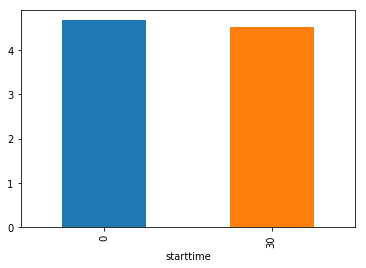

In [19]:
# how the score is going between class start at 00 and 30'
df_cl.groupby(df_cl.starttime.dt.minute).emotion_score.mean().plot(kind='bar')

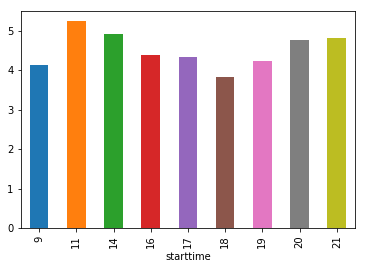

In [20]:
# how the score is going between class start at 00 and 30'
df_cl.groupby(df_cl.starttime.dt.hour).emotion_score.mean().plot(kind='bar')

In [82]:
init()

Initializing data


In [94]:
df_cl.starttime.dt.time.dtype

dtype('O')

In [83]:
df_cl_e.head()

,id_class,emotion_score,day_learned,is_completed,studentid,lessonid,lessonname,roomid,star,starttime,teacherid,kidname
0,5897.0,4.478814,0,1,292,312,Lesson 5,5897,5.0,2019-03-24 19:30:00,281,Lê Minh Hiếu
1,7655.0,4.078947,0,1,1562,461,trial,7655,NaN,2019-03-23 19:30:00,224,Đoàn Song Thư
2,7664.0,4.347273,0,1,1574,461,trial,7664,5.0,2019-03-23 18:30:00,224,Nguyễn Linh Đan
3,7691.0,4.000283,0,1,1580,461,trial,7691,NaN,2019-03-23 17:30:00,226,Triệu Bảo Anh
4,7700.0,3.521493,0,1,1508,461,trial,7700,1.0,2019-03-23 19:30:00,317,Đặng Quang Thắng


[autoreload of src.layouts.emotion_during_class failed: Traceback (most recent call last):
  File "/Users/qnkhuat/miniconda2/envs/dev/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/Users/qnkhuat/miniconda2/envs/dev/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/Users/qnkhuat/miniconda2/envs/dev/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/Users/qnkhuat/miniconda2/envs/dev/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "../src/layouts/emotion_during_class.py", line 54, in <module>
    options=[{'value':teacherid,'label':

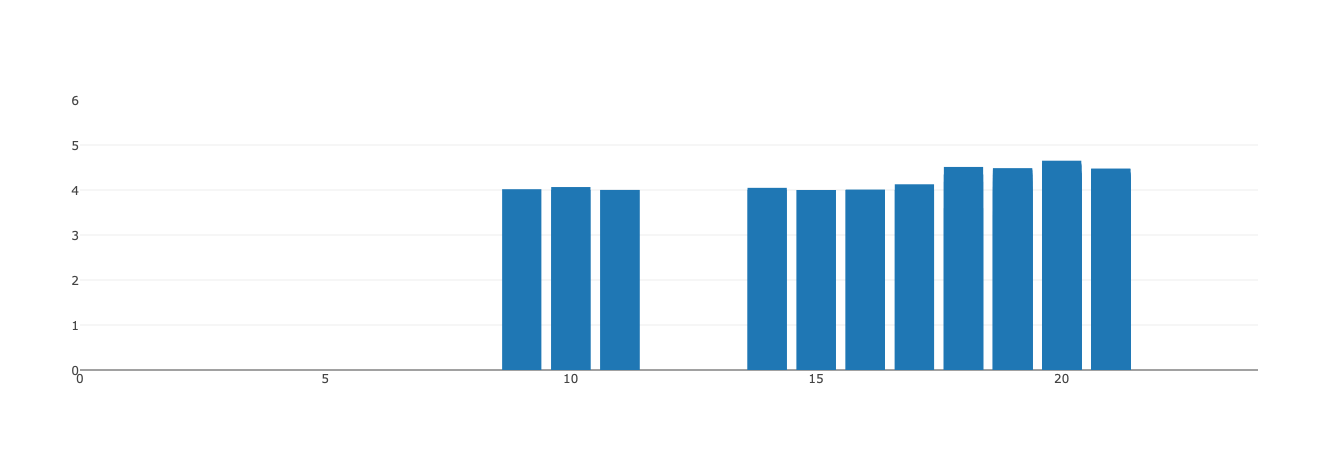

In [89]:
d1 = go.Bar(x=df_cl_e.starttime.dt.hour,y=df_cl_e.emotion_score)
l1 = go.Layout(
    hovermode='closest',
    xaxis={'range':[0,24]},
    yaxis={'range':[0,6]}
)
f1 = go.Figure(data=[d1],layout=l1)
pyo.iplot(f1)

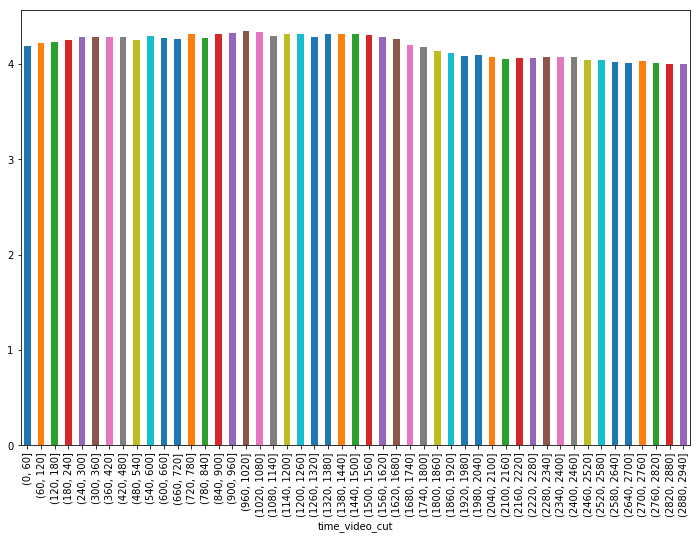

In [21]:
# emotion over length of class
plt.figure(figsize=(12,8))
df_e.groupby('time_video_cut').emotion_score.mean().plot(kind='bar')

In [98]:
df_e_gb_id = df_e.groupby('id_class')
df_e_gb_id[df_e_gb_id.user_role=='teacher']

KeyError: 'Column not found: False'

# regression emotion score

In [22]:
emotion_dict = {
    'emotion':[],
    'score':[]
}
for idx,row in df_e.iterrows():
    score = 0
    for c in emotion_score.keys():
        if c==None:continue
        score += row[c]*emotion_score[c]
    emotion_dict['emotion'].append(row.emotion)
    emotion_dict['score'].append(score)
df_emote = pd.DataFrame(emotion_dict)

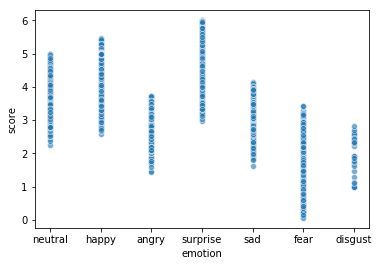

In [23]:
sns.scatterplot(x='emotion',y='score',data=df_emote,alpha=.6)

### Emotion by teacher id

In [ ]:
tid = 220
df_e_cl = df_e.merge(df_cl,on='id_class',suffixes=('','_avg'))

In [66]:
def trave_emotion_by_teacher(df,teacherid):
    df_e_cl_tid = df[df.teacherid==tid]
    data = []
    for cl in df_e_cl_tid.id_class.unique():
        df_sclass = get_sclass(df_e_cl_tid,cl)
        time_range = np.arange(0,df_sclass.time_video.max(),60)/60 # in minutes
        emotion_mean_by_range = df_sclass.groupby('time_video_cut').emotion_score.mean()
        trace = go.Scatter(
            x = time_range,
            y = emotion_mean_by_range,
            mode='lines',
            name = str(cl),
        )
        data.append(trace)
    return data


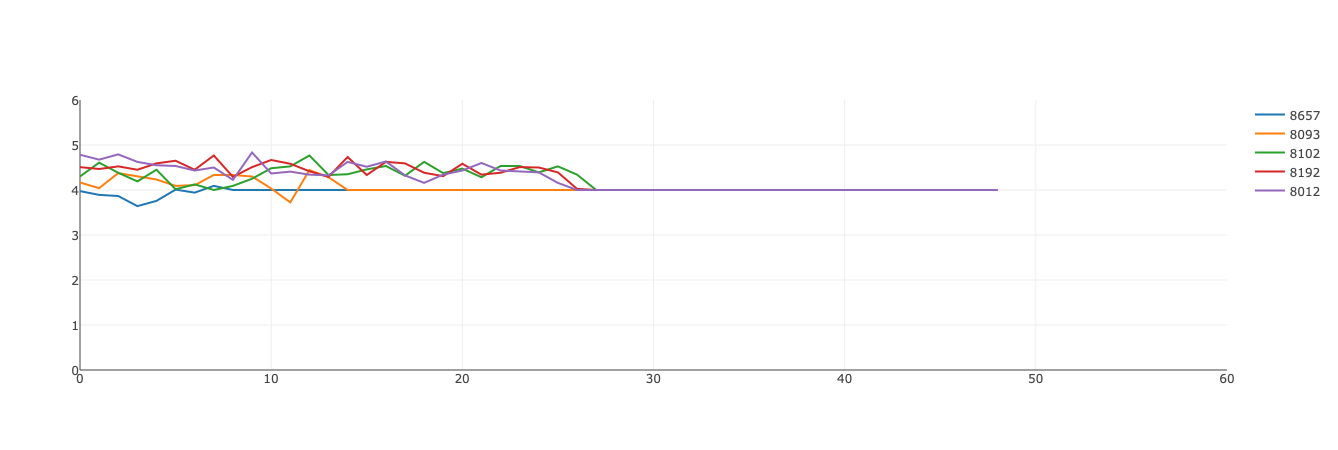

In [67]:
data = trave_emotion_by_teacher(df_e_cl,tid)
figure=go.Figure(data=data,layout=layout)
pyo.iplot(figure)

# smooth

In [70]:
def smooth2(x,y):
    print(len(x),len(y))
    from scipy.interpolate import make_interp_spline, BSpline
    xnew = np.linspace(x.min(),x.max(),50)
    spl = make_interp_spline(xnew,y,k=3)
    return spl(xnew)

In [73]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

In [74]:
df_sclass = df_e_cl[df_e_cl.id_class==c]
time_range = np.arange(0,df_sclass.time_video.max(),30)/60
df_sclass.loc[:,'time_video_cut'] = pd.cut(df_sclass.time_video,bins=np.arange(0,df_sclass.time_video.max(),30))
emotion_mean_by_range = df_sclass.groupby('time_video_cut').emotion_score.mean()
emotion_mean_by_range_smooth = smooth(emotion_mean_by_range,.8)

/Users/qnkhuat/miniconda2/envs/dev/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



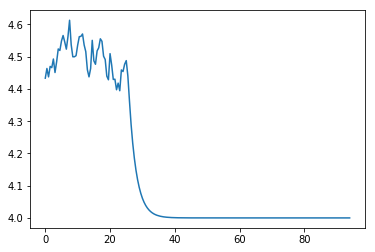

In [76]:
plt.plot(time_range[:-1],emotion_mean_by_range_smooth)

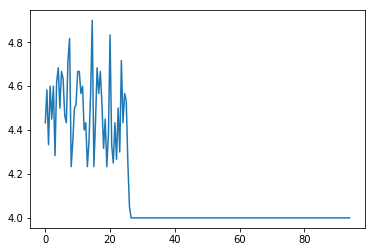

In [77]:
plt.plot(time_range[:-1],emotion_mean_by_range)